For the past couple of months or so, I've been spending time looking into transformers and BERT. Transformers are state of the art NLP models that are now replacing traditional RNNs in countless NLP tasks. One benefit of transformers is that, unlike RNNs, which require data to be input as a sequence, they can handle tokens all at once in parallel. 

This post is not going to be about transformers or BERT, but it does touch on a relevant topic. Transformers are huge architectures that can have as many as a few million trainable parameters. Hence, training transformers are extremely expensive, and only companies with a lot of computing resources can afford to train such models in their GPU or TPU clusters for extended periods of time. 

This is why so many people are interested in model compression. Huge models are not only difficult to train, but also requires good enough computing power. In other words, on-device inference is very difficult. People have thus started to look at various model compression techniques. Today, we will be discussing one such technique, known as knowledge distillation, introduced in [Distilling the Knowledge in a Neural Network](https://arxiv.org/abs/1503.02531), by Hinton et. al. Let's get started.

# Concept

In knowledge distillation, we assume two models: a teacher and student models. The teacher is the big, cumbersome model we seek to compress. As you may have guessed, the student is the compressed result of the teacher model. 

The object of knowledge distillation is to train the student to mimic the logits produced by the teacher. In other words, the student adjusts its parameters in the training phase such that its own logits output by the final layer is as close to that of the teacher model as possible. This is different from the typical training scheme in which we train the model on a set of hard, one-hot encoded labels in a supervised learning context. 

## Black Knowledge

Why might we want to do this? After all, don't we want the model to simply learn the dataset labels?

The motivation is that the teacher model possesses what the authors of the paper refer to as "dark knowledge." To make this more concrete, let's consider a simple example. Say we have trained a reasonably good model on the MNIST dataset. The model would, of course, accurately be able to predict which digit each image represents. If we show the model a 6, chances are, it will accurately predict that the number is a 6. No big deal here.

The interesting part occurs when we look at its logits. After a softmax activation, we might expect to see something like

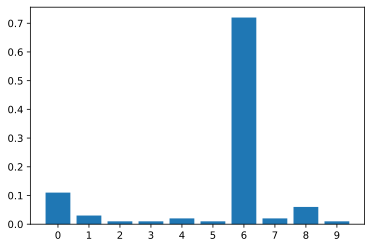

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "svg"

labels = list(range(0, 10))
logits = [0.11, 0.03, 0.01, 0.01, 0.02, 0.01, 0.72, 0.02, 0.06, 0.01]

plt.bar(labels, logits)
plt.xticks(range(len(labels)), labels)
plt.show()

We can see that the network correctly outputs 6 as the most probably digit by assigning it the largest logit. However, this is not the end of the story: we also see that the network has assigned a somewhat high probability to other numbers, such as 0 and 9. If you think about it, it kind of makes sense: given the shape of the digits, one would reasonably expect a 6 to look like 0, or vice versa, depending on the handwriting, and ditto the 9. 

Such implicit knowledge the model learns about the dataset is referred to as black knowledge. The goal of knowledge distillation is to be able to help the student model learn not only the true labels from the dataset, but also this dark knowledge that the larger teacher model has about the data. This is why we train the student model on the logits of the teacher model.

## Temperature

There are several simplifications we've made so far in our explanation. One major simplification is how we treat the logits from the teacher model. If you look at the diagram above, the amount of dark knowledge that can be gained is relatively little. If the model is well-trained enough, perhaps it will predict the digit 6 with an even higher number of confidence, thus ascribing lesser probabilities to other labels like 0 or 9. So ironically, the better the teacher model is, the lesser dark knowledge there is to be gained by the student model. 

The authors circumvent this problem by adjusting the final softmax output of the teacher model. Recall that the softmax activation function looks as follows:

$$
\text{softmax}(z_i) = \frac{\text{exp}(z_i)}{\sum_{n=1}^N \text{exp}(z_n)} \tag{1}
$$

Due to the nature of the exponential function, the softmax function is designed in such a way that larger logits are amplified, whereas smaller ones are squashed near zero. From a dark knowledge point of view, this is not great, as it makes it more difficult for the student model to learn the dark knowledge from the teacher. 

Thus, the authors of the paper introduce a temperature parameter to modify the softmax function. Let's denote this as softmax prime.

$$
\text{softmax}^\prime(z_i, T) = \frac{\text{exp}\left(\frac{z_i}{T} \right)}{\sum_{n=1}^N \text{exp}\left(\frac{z_n}{T} \right)} \tag{2}
$$

When $T = 1$, it is identical to the softmax function. When $T$ gets larger, it smoothens the distribution. This is because the derivative of the exponential function near smaller values are smaller compared to that at larger values. To put this into perspective, let's write a simple function that demonstrates this observation visually.

In [10]:
import numpy as np

def softmax_prime(z, T):
    z = np.asarray(z) / T
    numerator = np.exp(z)
    denominator = np.sum(numerator)
    return numerator / denominator

`softmax_prime()` is a code translation of (2) above. Note that we could have made this more numerically stable by subtracting the maximum value from the logits. But for sake of simplicity, we implement the formula as-is.

Now, we can see how different temperature values yield different softmax outputs. Here, we consider integer temperature values from 1 to 5, inclusive.

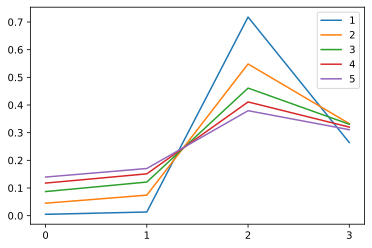

In [21]:
Ts = range(1, 6)
raw_logits = [-1, 0, 4, 3]
labels = range(len(raw_logits))
fig, ax = plt.subplots()

for T in Ts:
    ax.plot(labels, softmax_prime(raw_logits, T), label=f"{T}")
ax.set_xticks(labels)
ax.legend()
plt.show()

From the graph, one can easily see that the higher the temperature value, the smoother the distribution becomes. In other words, it makes it easier for the student model to learn dark knowledge. This softmax variation is key to knowledge distillation. 

## Loss Function

Since we now train the student model on both the soft label logits of the teacher model and the hard labels from the dataset, it is necessary to revisit what the loss function is.

To cut to the chase, the loss function in knowledge distillation is a combined loss of weighted averages: the cross entropy between the student model outputs and labels, as well as the Kullback–Leibler divergence between the temperature-adjusted student and teacher model logits. More concisely, 

$$
L_\text{total} = \alpha D_{KL}(\sigma^\prime(z_s, T) \Vert \sigma^\prime(z_t, T)) + (1 - \alpha) H(\sigma(z_s), \sigma(y_\text{true})) \tag{3}
$$

where $\sigma(\cdot)$ denotes the softmax function, $\sigma^\prime(\cdot, T)$ denotes softmax prime with adjusted temperature, $z_t$ denotes the raw logits of the teacher model, and $\alpha$ is a weighted average parameter. 

While this might seem like a lot, in reality it is just the weighted average of the normal cross entropy loss that we would use in typical training, combined with the KL divergence loss between the temperature-adjusted softmax outputs of the student and teacher model. Intuitively, we can understand the KL divergence as an additional form of regularization that forces the student network to not only train on hard ground-truth labels, but also the dark knowledge coming from the outputs of the teacher model.

Now that we have an overall idea of how knowledge distillation works, let's start implementing knowledge distillation training.

# Implementation

Before we move on, full disclaimer that this experiment did not go as I had expected. As you will see below, somehow the distilled student model ended up outperforming the teacher, which is something that normally does not happen. In a later section, I will try to provide some hypotheses as to why this happened.

## Setup

Let's import necessary modules for this tutorial.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(123)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We define a transformation we will be applying to each image. 

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

We can then create a training set and a testing set. Note that I didn't have to download anything because I already had all my files on my local machine.

In [3]:
train_set = datasets.MNIST(
    './data', train=True, download=True, transform=transform
)
test_set = datasets.MNIST(
    './data', train=False, download=True, transform=transform
)

Next, we create data loaders with a batch size of 64.

In [4]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

## Modeling

Modeling is very dull and uninteresting here; we simply define a relatively large teacher model and a smaller student model. As per the experiment outlined in the original paper, we define a multi-layer perceptron with two hidden layers, each with 1200 units. The teacher network also uses dropout for regularization. 

In [5]:
class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 1200)
        self.fc2 = nn.Linear(1200, 1200)
        self.fc3 = nn.Linear(1200, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.reshape(-1, 28 * 28)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

Next up is the student model. The student model is a smaller version of the teacher network. It has two hidden layers, but 800 units as opposed to 1200. It also does not employ any dropout.

In [7]:
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 800)
        self.fc2 = nn.Linear(800, 800)
        self.fc3 = nn.Linear(800, 10)

    def forward(self, x):
        x = x.reshape(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

To get a sense of how large the teacher model is in comparison to the student network, let's count the number of trainable parameters in each. Below is a function that accomplishes this task.

In [9]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Now we can check how many parameters the teacher and student models have.

In [10]:
teacher = Teacher().to(device)
teacher_size = count_params(teacher)
teacher_size

2395210

In [11]:
student = Student().to(device)
student_size = count_params(student)
student_size

1276810

From this comparison, we can see that the student model is roughly half the size of the teacher model. We could consider this percentage the degree of compression we wish to perform through knowledge distillation.

In [12]:
print(f"{student_size / teacher_size * 100: .3f}")

 53.307


## Knowledge Distillation

This is where all the fun stuff happens. First, let's implement the knowledge distillation loss function as defined in (3). Note that we don't calculate the weighted average yet; we simply return the two loss sub-components. 

In [13]:
def distill(labels, student_outputs, teacher_outputs, T):
    ce_loss = F.cross_entropy(student_outputs, labels)
    distill_loss = F.kl_div(
        F.log_softmax(student_outputs / T, dim=1), 
        F.softmax(teacher_outputs / T, dim=1)
    )
    return ce_loss, distill_loss

The first component, `ce_loss`, is no different from loss value calculations we saw in typical classification tasks. `distill_loss` is the added component, which is the KL divergence between the temperature-adjusted softmax outputs of the student and teacher models. 

Now that we have all the ingredients we need, let's write the knowledge distillation training loop. In the loop, we invoke the `distill()` function, apply a weighted average, and backpropagate on the combined loss. 

One technicality we have not touched upon earlier is the fact that we need to apply some scaling to the KL divergence loss. The gradient of the `distill_loss` term, compared to `ce_loss`, is smaller by a factor of $\frac{1}{T^2}$. Thus, we need to multiply $T^2$ to correct this difference in magnitude. 

In [14]:
def train(student, teacher, train_loader):
    student.train()
    teacher.eval()
    total_ce_loss = 0
    total_distill_loss = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        teacher_outputs = teacher(inputs)
        student_outputs = student(inputs)
        
        ce_loss, distill_loss = distill(labels, student_outputs, teacher_outputs, T)
        loss = (1 - alpha) * ce_loss + (alpha * T ** 2) * distill_loss
        loss.backward()
        optimizer.step()
        
        total_ce_loss += ce_loss.cpu().item()
        total_distill_loss += distill_loss.cpu().item()
        
    print(
        f"Distill Loss: {total_distill_loss / len(train_loader):3f}, "
        f"CE Loss: {total_ce_loss / len(train_loader):.3f}"
    )
        

Let's also write a training loop for just training the model as is. We will essentially conduct a controlled experiment where we compare the result of knowledge distillation and vanilla training.

In [15]:
def train_no_distill(model, train_loader):
    model.train()
    total_loss = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.cpu().item()
        
    print(
        f"Loss: {total_loss / len(train_loader):3f}"
    )

And here is a simple evaluation function we will use to check the performance of each model at the end of training. Since we are merely evaluating the model, we don't need to keep gradients. 

In [16]:
@torch.no_grad()
def evaluate(model, data_loader):
    model.eval()
    num_total = 0
    num_correct = 0
    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).to(int)
        
        outputs = model(inputs)
        _, pred = outputs.max(1)
        num_total += len(labels)
        num_correct += (pred == labels).cpu().sum()
    print(f"Accuracy: {num_correct / num_total :.3f}")

## Result

First, we train the teacher model. After 10 epochs, the teacher model manages to get an accuracy of around 98 percent. 

In [17]:
num_epochs = 10
optimizer = torch.optim.Adam(teacher.parameters())

print("...Training Teacher Model...")
for epoch in range(num_epochs):
    train_no_distill(teacher, train_loader)
print("...Testing...")
evaluate(teacher, test_loader)

...Training Teacher Model...
Loss: 0.288360
Loss: 0.178093
Loss: 0.157694
Loss: 0.148247
Loss: 0.139925
Loss: 0.133539
Loss: 0.133046
Loss: 0.125003
Loss: 0.123230
Loss: 0.124310
...Testing...
Accuracy: 0.979


Next, we train the student model using the typical training scheme without knowledge distillation. Using this method, the student model manages to get an accuracy of 98 percent; in fact, 0.1 percentage point higher than that of the teacher model.

In [19]:
student_no_distill = Student().to(device)
optimizer = torch.optim.Adam(student_no_distill.parameters())

print("...Training Student Model...")
for epoch in range(num_epochs):
    train_no_distill(student_no_distill, train_loader)
print("...Testing...")
evaluate(student_no_distill, test_loader)

...Training Student Model...
Loss: 0.191698
Loss: 0.086312
Loss: 0.064181
Loss: 0.049171
Loss: 0.040704
Loss: 0.034594
Loss: 0.029687
Loss: 0.025086
Loss: 0.026712
Loss: 0.025699
...Testing...
Accuracy: 0.980


At this point, I already knew that something was off, but I decided to continue with the experiment. Finally, we train a brand new student model through knowledge distillation. And interestingly enough, the knowledge distilled student model records an accuracy score of 98.1 percent.

In [21]:
T = 20
alpha = 0.7
student = Student().to(device)
optimizer = torch.optim.Adam(student.parameters())

print("...Distilling Student Model...")
for epoch in range(num_epochs):
    train(student, teacher, train_loader)
print("...Testing...")
evaluate(student, test_loader)

...Distilling Student Model...


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Distill Loss: 0.001242, CE Loss: 0.229
Distill Loss: 0.000288, CE Loss: 0.055
Distill Loss: 0.000221, CE Loss: 0.034
Distill Loss: 0.000186, CE Loss: 0.026
Distill Loss: 0.000165, CE Loss: 0.020
Distill Loss: 0.000155, CE Loss: 0.017
Distill Loss: 0.000143, CE Loss: 0.014
Distill Loss: 0.000133, CE Loss: 0.013
Distill Loss: 0.000128, CE Loss: 0.011
Distill Loss: 0.000115, CE Loss: 0.010
...Testing...
Accuracy: 0.981


Why might have been the case? There are several things I think were happening in this example. The first is that the teacher model did not have enough helpful dark knowledge. In this experiment, I trained both the teacher and student models for 10 epochs. In retrospect, the teacher model should have been trained for a longer period of time to achieve the best performance possible, and thus learn enough helpful dark knowledge that could then be distilled onto the student network. Had we used some huge ImageNet-based model on CIFAR 100, we would have probably seen more interesting results through distillation. 

This relates to my second hypothesis, which is that the dataset was perhaps too simple for the networks. The student network was able to achieve a 98 percent point accuracy by training on the hard labels. This perhaps suggests that what we used as the student network itself could have been a teacher network of its own. Perhaps the student model should have been an even smaller network than the one we experimented with here. 

# Conclusion

Although our attempt at knowledge distillation did not quite go as we had expected, nonetheless I think it was a great opportunity for me to learn about an exciting area of research. I also think understanding knowledge distillation will be helpful when using larger transformer models. I personally prefer smaller models like DistilBERT than full-fledged super transformers like RoBERTA large. In using transformers and fiddling with them, I think understanding distillation will open up more possibilities for me, and at least give me more confidence when using distilled models for my experiments. 

I hope you've enjoyed reading this post. Catch you up in the next one!